# Otimização do setup de CATAN com Programação Linear Inteira (MILP)

- Modelagem em termos de variáveis binárias $x_v$ (vértices com vilas) e $y_n$ (números cobertos).
- Função objetivo: maximizar
  
  $$Z(x, y) = \alpha \cdot E_{total}(x) + (1-\alpha) \cdot P_{ganho}(x)$$

  onde:
  - $E_{total}(x)$ é a produção esperada de recursos por turno;
  - $P_{ganho}(x)$ é a probabilidade de ganhar recurso em um turno.

- Restrições principais:
  - exatamente 2 vilas iniciais;
  - vilas não podem estar em vértices adjacentes;
  - $y_n$ só pode ser 1 se algum vértice com vila enxergar o número $n$.

Resolução feita com a biblioteca **PuLP** (solver padrão CBC).
```bash
pip install pulp
```

In [41]:
import math
import random
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from collections import defaultdict

import pulp  # biblioteca de modelagem de PL/MILP em Python

# Para resultados reproduzíveis (mesmo tabuleiro aleatório sempre):
random.seed()

## 1. Geometria do tabuleiro (coordenadas dos hexágonos e vértices)

- gerar as coordenadas axiais $(q, r)$ para os hexágonos do tabuleiro de Catan;
- converter para coordenadas $(x, y)$;
- identificar quais vértices são compartilhados por quais hexágonos;
- identificar quais vértices são adjacentes (compartilham uma aresta).

In [42]:
def gerar_centro_hexagonos_axiais(raio):
    """Gera as coordenadas axiais (q, r) do centro dos hexágonos,
    em um tabuleiro com forma de hexágono grande. Totaliza 19 hexágonos.
    """
    hexagonos = []
    for q in range(-raio, raio + 1):
        for r in range(-raio, raio + 1):
            # Condição que recorta o hexágono grande na grade axial
            if -raio <= q + r <= raio:
                hexagonos.append((q, r))
    return hexagonos


def hex_axial_para_xy(q, r, tamanho=1.0):
    """Converte coordenadas axiais (q, r) em coordenadas (x, y) no plano,
    assumindo hexágonos de topo pontudo (pointy-top).
    """
    x = tamanho * (math.sqrt(3) * (q + r / 2))
    y = tamanho * (1.5 * r)
    return x, y


def construir_geometria_tabuleiro(raio=2, tamanho=1.0, tolerancia=1e-6):
    """Constrói a geometria do tabuleiro e retorna um dicionário com:

    - 'hex_centros_axiais': lista de (q, r) de cada hexágono;
    - 'hex_centros': lista de (x, y) dos centros;
    - 'vertices_coordenadas': lista de (x, y) de cada vértice;
    - 'hex_para_vertices': para cada hex, os 6 vértices (índices);
    - 'vertice_para_hexs': para cada vértice, lista de hexágonos adjacentes;
    - 'vizinhos_vertices': para cada vértice, um set de vértices adjacentes.
    """
    hex_centros_axiais = gerar_centro_hexagonos_axiais(raio)
    hex_centros = [hex_axial_para_xy(q, r, tamanho) for (q, r) in hex_centros_axiais]
    
    # Ordenar hexágonos por posição visual, de cima para baixo e da esquerda para a direita
    indices_ordenados = sorted(
        range(len(hex_centros)),
        key=lambda i: (-hex_centros[i][1], hex_centros[i][0]))
    hex_centros_axiais = [hex_centros_axiais[i] for i in indices_ordenados]
    hex_centros = [hex_centros[i] for i in indices_ordenados]

    mapa_vertices = {}          # {(x, y) : índice do vértice, ...}
    vertices_coordenadas = []   # [(x, y), ...]
    hex_para_vertices = []      # [[6 índices de vértices], ...]
    vertice_para_hexs = defaultdict(list) # {indice do vértice: [hexágonos adjacentes], ...}

    def adicionar_vertice(x, y):
        # Arredondar os valores para evitar duplicação de vértices
        chave = (round(x / tolerancia) * tolerancia,
                 round(y / tolerancia) * tolerancia)
        if chave not in mapa_vertices:
            indice = len(mapa_vertices)
            mapa_vertices[chave] = indice
            vertices_coordenadas.append(chave)
        return mapa_vertices[chave]

    # Para cada hexágono, calcular os 6 cantos
    for cx, cy in hex_centros:
        vertices_hex = []
        for i in range(6):
            angulo_rad = math.radians(60 * i + 30)
            vx = cx + tamanho * math.cos(angulo_rad)
            vy = cy + tamanho * math.sin(angulo_rad)
            v = adicionar_vertice(vx, vy)
            vertices_hex.append(v)
        hex_para_vertices.append(vertices_hex)

    # Mapa vértice -> hexágonos adjacentes
    for hex_indice, lista_v in enumerate(hex_para_vertices):
        for v in lista_v:
            vertice_para_hexs[v].append(hex_indice)

    # Adjacência entre vértices {vértice: {vértices adjacentes}, ...}
    vizinhos_vertices = {i: set() for i in range(len(vertices_coordenadas))}
    for lista_v in hex_para_vertices:
        for i in range(6):
            v1 = lista_v[i]
            v2 = lista_v[(i + 1) % 6] # %6 reinicia o indice
            vizinhos_vertices[v1].add(v2)
            vizinhos_vertices[v2].add(v1)

    return {
        'hex_centros_axiais': hex_centros_axiais,
        'hex_centros': hex_centros,
        'vertices_coordenadas': vertices_coordenadas,
        'hex_para_vertices': hex_para_vertices,
        'vertice_para_hexs': vertice_para_hexs,
        'vizinhos_vertices': vizinhos_vertices,
    }


geometria = construir_geometria_tabuleiro(raio=2)

print('--- Coordenadas organizadas ---')
print(geometria['hex_centros_axiais'])
print(geometria['hex_centros'])

num_hexagonos = len(geometria['hex_centros_axiais'])
num_vertices = len(geometria['vertices_coordenadas'])

print(f'\nHexágonos: {num_hexagonos}, Vértices: {num_vertices}')

--- Coordenadas organizadas ---
[(-2, 2), (-1, 2), (0, 2), (-2, 1), (-1, 1), (0, 1), (1, 1), (-2, 0), (-1, 0), (0, 0), (1, 0), (2, 0), (-1, -1), (0, -1), (1, -1), (2, -1), (0, -2), (1, -2), (2, -2)]
[(-1.7320508075688772, 3.0), (0.0, 3.0), (1.7320508075688772, 3.0), (-2.598076211353316, 1.5), (-0.8660254037844386, 1.5), (0.8660254037844386, 1.5), (2.598076211353316, 1.5), (-3.4641016151377544, 0.0), (-1.7320508075688772, 0.0), (0.0, 0.0), (1.7320508075688772, 0.0), (3.4641016151377544, 0.0), (-2.598076211353316, -1.5), (-0.8660254037844386, -1.5), (0.8660254037844386, -1.5), (2.598076211353316, -1.5), (-1.7320508075688772, -3.0), (0.0, -3.0), (1.7320508075688772, -3.0)]

Hexágonos: 19, Vértices: 54


## 2. Probabilidades dos dados e números dos hexágonos

definir a distribuição de 2 d6 e atribuir números aos hexágonos:
- lista oficial de Catan inclui 19 fichas numéricas e 19 hexágonos
- números 2-12 duplicados, exceto o 2, 7 (ladrão) e o 12

In [43]:
# Probabilidades dos resultados ao lançar dois dados de seis faces
prob_dados = {
    2: 1 / 36,
    3: 2 / 36,
    4: 3 / 36,
    5: 4 / 36,
    6: 5 / 36,
    7: 0, # o 7 não produz recursos (6 / 36 na teoria)
    8: 5 / 36,
    9: 4 / 36,
    10: 3 / 36,
    11: 2 / 36,
    12: 1 / 36,
}


def gerar_numeros_hexagonos(quantidade=19):
    """Gera uma lista de números (valores dos dados)
    para atribuir aos hexágonos do tabuleiro."""
    if quantidade == 19:
        # Lista oficial do Catan padrão
        tokens_base = [2, 3, 3, 4, 4, 5, 5, 6, 6, 7,
                       8, 8, 9, 9, 10, 10, 11, 11, 12]  
        random.shuffle(tokens_base)
    else:
        # Gerar lista aleatória para tabuleiros de tamanho diferente
        tokens_base = [random.randint(2, 12) for i in range(quantidade)]
    
    return tokens_base

# deixar lista vazia para ordenação aleatória
input_manual = [8, 10, 2, 11, 9, 8, 3, 9, 5, 12, 9, 6, 10, 3, 6, 11, 4, 5, 4]
assert len(input_manual) == num_hexagonos or len(input_manual) == 0

numeros_hex = input_manual or gerar_numeros_hexagonos(num_hexagonos)

print('Números atribuídos aos hexágonos:')
print(numeros_hex)

Números atribuídos aos hexágonos:
[8, 10, 2, 11, 9, 8, 3, 9, 5, 12, 9, 6, 10, 3, 6, 11, 4, 5, 4]


## 3. Preparação dos parâmetros para o modelo MILP

Calcular:
- coeficiente de produção esperada de cada vértice:
  
  $$c_v = \sum_{h \text{ adjacente a } v} P(d(h))$$

- conjuntos $V_n$ (vértices que enxergam pelo menos um hex de número $n$),
  para $n$ em $N = \{2,3,4,5,6,8,9,10,11,12\}$.

In [44]:
vertice_para_hexs = geometria['vertice_para_hexs']
hex_centros_axiais = geometria['hex_centros_axiais']

# Coeficientes c_v para E_total
coef_producao_vertice = {}
for v in range(num_vertices):
    hexes_adj = vertice_para_hexs[v]
    coef = sum(prob_dados[numeros_hex[h]] for h in hexes_adj)
    coef_producao_vertice[v] = coef

# Conjuntos V_n: vértices que veem o número n
V_n = {n: set() for n in range(2, 13)}
for h, num in enumerate(numeros_hex):
    for v in geometria['hex_para_vertices'][h]:
        V_n[num].add(v)

print('Coeficiente de produção esperada para alguns vértices:')
for v in range(5):
    print(f'v={v}: c_v = {coef_producao_vertice[v]:.3f}')

print('\nTamanho de V_n (para cada número n):')
for n in range(2, 13):
    print(f'n={n}: |V_n| = {len(V_n[n])}')

Coeficiente de produção esperada para alguns vértices:
v=0: c_v = 0.222
v=1: c_v = 0.139
v=2: c_v = 0.139
v=3: c_v = 0.194
v=4: c_v = 0.306

Tamanho de V_n (para cada número n):
n=2: |V_n| = 6
n=3: |V_n| = 12
n=4: |V_n| = 12
n=5: |V_n| = 12
n=6: |V_n| = 12
n=7: |V_n| = 0
n=8: |V_n| = 12
n=9: |V_n| = 18
n=10: |V_n| = 12
n=11: |V_n| = 12
n=12: |V_n| = 6


## 4. Modelo MILP com PuLP

Variáveis de decisão:

- $x_v \in \{0,1\}$; 1 se existe uma vila no vértice $v$;
- $y_n \in \{0,1\}$; 1 se pelo menos uma das vilas é adjacente a um hexágono com número $n$.

Função objetivo:

\begin{align}
E_{total}(x) &= \sum_v c_v x_v \\
P_{ganho}(x) &= \sum_n p_n y_n \\
Z(x, y) &= \alpha E_{total}(x) + (1-\alpha) P_{ganho}(x)
\end{align}

Restrições principais:

1. $\sum_v x_v = 2$ (duas vilas iniciais)
2. $x_v + x_u \leq 1$ para vértices adjacentes (vilas não podem ser adjacentes)
3. $y_n \leq \sum_{v \in V_n} x_v$ para todo $n \in N$.

In [45]:
def resolver_modelo_catan(alfa=0.6):
    """Monta e resolve o modelo MILP do CATAN para um dado alfa.

    Retorna:
      - modelo PuLP,
      - solução x_v (dict),
      - solução y_n (dict),
      - expressões simbólicas E_total e P_ganho (para avaliar valores).
    """
    modelo = pulp.LpProblem('Setup_Catan', pulp.LpMaximize)

    # Variáveis binárias x_v
    x = {
        v: pulp.LpVariable(f'x_{v}', lowBound=0, upBound=1, cat=pulp.LpBinary)
        for v in range(num_vertices)
    }

    # Variáveis binárias y_n (apenas onde V_n não é vazio)
    y = {
        n: pulp.LpVariable(f'y_{n}', lowBound=0, upBound=1, cat=pulp.LpBinary)
        for n in range(2, 13)
    }

    # E_total = sum_v c_v * x_v
    E_total_formula = pulp.lpSum(coef_producao_vertice[v] * x[v] for v in range(num_vertices))

    # P_ganho = sum_n P(n) * y_n
    P_ganho_formula = pulp.lpSum(prob_dados[n] * y[n] for n in y.keys())

    # Função objetivo Z = alfa * E_total + (1 - alfa) * P_ganho
    modelo += alfa * E_total_formula + (1 - alfa) * P_ganho_formula, 'FuncaoObjetivo'

    # Restrição: exatamente 2 vilas
    modelo += pulp.lpSum(x[v] for v in range(num_vertices)) == 2, 'DuasVilas'

    # Restrição de não-adjacência entre vértices
    vizinhos_vertices = geometria['vizinhos_vertices']
    for v in range(num_vertices):
        for u in vizinhos_vertices[v]:
            if u > v:  # garantir que cada par (v, u) apareça apenas uma vez
                modelo += x[v] + x[u] <= 1, f'NaoAdjacentes_{v}_{u}'

    # Restrição do y_n para ser 1 apenas se algum x_v em V_n for 1
    for n in y.keys():
        modelo += y[n] <= pulp.lpSum(x[v] for v in V_n[n]), f'Ligacao_y_{n}'

    # Resolver o modelo
    modelo.solve(pulp.PULP_CBC_CMD(msg=False))

    # Extrair soluções
    sol_x = {v: x[v].value() for v in range(num_vertices)}
    sol_y = {n: y[n].value() for n in y.keys()}

    return modelo, sol_x, sol_y, E_total_formula, P_ganho_formula

# escolher peso entre a produção esperada e a regularidade de produção
alfa = 0.5
modelo, sol_x, sol_y, E_total_formula, P_ganho_formula = resolver_modelo_catan(alfa=alfa)

print('Status da solução:', pulp.LpStatus[modelo.status])

# Vértices onde x_v = 1
vilas = [v for v, val in sol_x.items() if val == 1]
print('Vértices escolhidos para vilas:', vilas)

E_total_val = pulp.value(E_total_formula)
P_ganho_val = pulp.value(P_ganho_formula)
Z_val = pulp.value(modelo.objective)

print(f'E_total = {E_total_val:.4f}')
print(f'P_ganho  = {P_ganho_val:.4f}')
print(f'Z = alfa * E_total + (1 - alfa) * P_ganho = {Z_val:.4f}')

Status da solução: Optimal
Vértices escolhidos para vilas: [5, 43]
E_total = 0.6667
P_ganho  = 0.6667
Z = alfa * E_total + (1 - alfa) * P_ganho = 0.6667


## 5. Inspecionando os vértices escolhidos

Inspecionar os vértices onde $x_v = 1$:
- quais hexágonos estão adjacentes;
- quais números esses hexágonos possuem;
- a produção esperada individual $E(v)$.

In [46]:
def producao_esperada_vertice(v, numeros_hex, geometria, prob_dados):
    hexes_adj = geometria['vertice_para_hexs'][v]
    return sum(prob_dados[numeros_hex[h]] for h in hexes_adj)


def imprimir_info_vertice(v):
    print(f'\nVértice v = {v}')
    hexes_adj = geometria['vertice_para_hexs'][v]
    for h in hexes_adj:
        q, r = geometria['hex_centros_axiais'][h]
        num = numeros_hex[h]
        print(f'  Hex {h:2d} (q={q:+2d}, r={r:+2d}) -> número {num}, P={prob_dados[num]:.3f}')
    E_v = producao_esperada_vertice(v, numeros_hex, geometria, prob_dados)
    print(f'  E(v) = {E_v:.4f}')


for v in vilas:
    imprimir_info_vertice(v)

print('\nChecando soma E(v) das vilas:')
soma_E = sum(producao_esperada_vertice(v, numeros_hex, geometria, prob_dados) for v in vilas)
print(f'Soma E(vilas) = {soma_E:.4f} = E_total')


Vértice v = 5
  Hex  0 (q=-2, r=+2) -> número 8, P=0.139
  Hex  1 (q=-1, r=+2) -> número 10, P=0.083
  Hex  4 (q=-1, r=+1) -> número 9, P=0.111
  E(v) = 0.3333

Vértice v = 43
  Hex 14 (q=+1, r=-1) -> número 6, P=0.139
  Hex 17 (q=+1, r=-2) -> número 5, P=0.111
  Hex 18 (q=+2, r=-2) -> número 4, P=0.083
  E(v) = 0.3333

Checando soma E(v) das vilas:
Soma E(vilas) = 0.6667 = E_total


## 6. Visualização do tabuleiro e das vilas escolhidas

Usar `matplotlib` para desenhar o mapa final

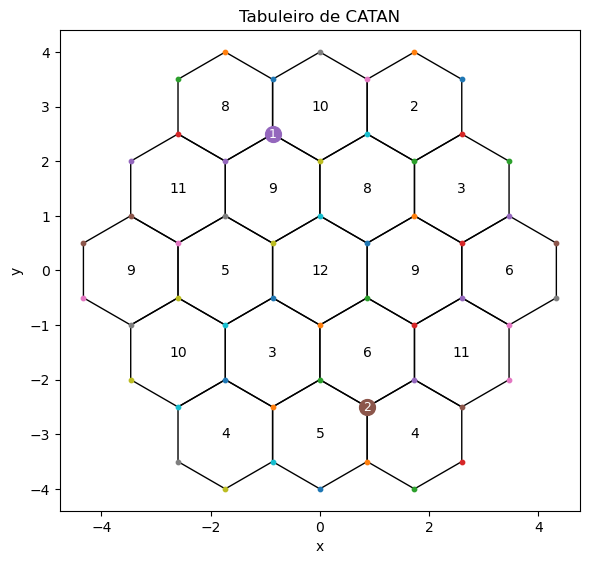

In [47]:
def plotar_tabuleiro(geometria, numeros_hex, vilas=None, tamanho=1.0, mostrar_indices=True):
    """
    Desenha o tabuleiro de hexágonos + vértices.

    - hexágonos: desenhados como polígonos regulares de 6 lados;
    - números dos hex: mostrados no centro;
    - vértices: desenhados como pontos;
    - vilas (lista de índices de vértice): destacados em tamanho maior.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plotar os hexágonos
    for h_idx, (cx, cy) in enumerate(geometria["hex_centros"]):
        hex_patch = RegularPolygon(
            (cx, cy),
            numVertices=6,
            radius=tamanho,
            fill=False,
            linewidth=1.0,
        )
        ax.add_patch(hex_patch)

        # número do hex (token de dado)
        ax.text(cx, cy, str(numeros_hex[h_idx]),
                ha="center", va="center", fontsize=10)

    # enumerar os vértices
    for v_idx, (vx, vy) in enumerate(geometria["vertices_coordenadas"]):
        ax.scatter(vx, vy, s=10)
        if mostrar_indices:
            ax.text(vx, vy, str(v_idx),
                    ha="center", va="center", fontsize=7, color="Black", backgroundcolor="yellow")

    # marcar vilas escolhidas
    for i, v in enumerate(vilas):
        vx, vy = geometria["vertices_coordenadas"][v]
        ax.scatter(vx, vy, s=130, marker="o")
        ax.text(vx, vy, i+1,
                ha="center", va="center", fontsize=9, color="white")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Tabuleiro de CATAN")

    plt.tight_layout()
    plt.show()

plotar_tabuleiro(geometria, numeros_hex, vilas=vilas, tamanho=1.0, mostrar_indices=False)


## 7. Visualização do espaço de soluções

Visualizar todas as combinações viáveis de 2 vilas e o trade-off entre $E_{total}$ (produção esperada) e $P_{ganho}$ (regularidade).

Total de combinações viáveis: 1359
E_total: min=0.0833, max=0.6667
P_gain: min=0.0556, max=0.6667


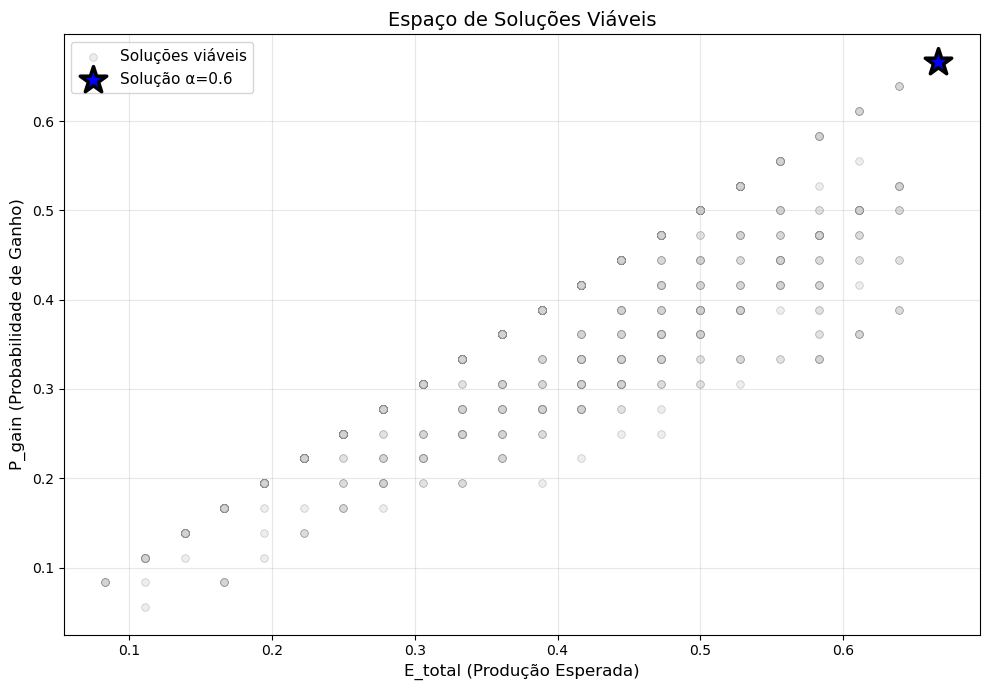

In [ ]:
import numpy as np
from itertools import combinations

# Gerar todas as combinações viáveis de 2 vilas (não adjacentes)
combinacoes_viaveis = []
for v1, v2 in combinations(range(num_vertices), 2):
    if v2 not in geometria['vizinhos_vertices'][v1]:
        combinacoes_viaveis.append((v1, v2))

print(f'Total de combinações viáveis: {len(combinacoes_viaveis)}')

# Calcular E_total e P_gain para cada combinação
E_totals = []
P_gains = []

for v1, v2 in combinacoes_viaveis:
    # E_total
    E_total = coef_producao_vertice[v1] + coef_producao_vertice[v2]
    
    # P_gain (números únicos cobertos)
    numeros_cobertos = set()
    for v in [v1, v2]:
        for h in vertice_para_hexs[v]:
            numeros_cobertos.add(numeros_hex[h])
    P_gain = sum(prob_dados[n] for n in numeros_cobertos)
    
    E_totals.append(E_total)
    P_gains.append(P_gain)

E_totals = np.array(E_totals)
P_gains = np.array(P_gains)

print(f'E_total: min={E_totals.min():.4f}, max={E_totals.max():.4f}')
print(f'P_gain: min={P_gains.min():.4f}, max={P_gains.max():.4f}')

# Visualizar
plt.figure(figsize=(10, 7))

# Todas as soluções viáveis
plt.scatter(E_totals, P_gains, s=30, alpha=0.4, color='lightgray', 
            edgecolors='gray', linewidths=0.5, label='Soluções viáveis')

# Solução com α=0.6
plt.scatter(E_total_val, P_ganho_val, s=400, color='blue', marker='*', 
            edgecolors='black', linewidths=2.5, label='Solução α=0.6', zorder=10)

plt.xlabel('E_total (Produção Esperada)', fontsize=12)
plt.ylabel('P_gain (Probabilidade de Ganho)', fontsize=12)
plt.title('Espaço de Soluções Viáveis', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()